# Pixel classification in multi-channel images


In [1]:
from skimage.data import cells3d
from skimage.io import imsave, imread
import numpy as np
import apoc
import stackview

In [2]:
image = cells3d()

StackViewNDArray([[4496, 5212, 6863, ..., 2917, 2680, 2642],
                  [4533, 5146, 7555, ..., 2843, 2857, 2748],
                  [4640, 6082, 8452, ..., 3372, 3039, 3128],
                  ...,
                  [1339, 1403, 1359, ..., 4458, 4314, 4795],
                  [1473, 1560, 1622, ..., 3967, 4531, 4204],
                  [1380, 1368, 1649, ..., 3091, 3558, 3682]], dtype=uint16)
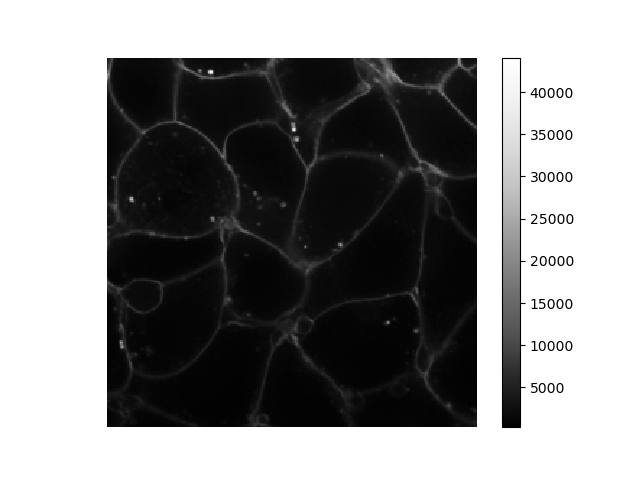
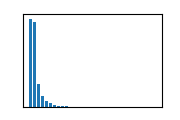

In [3]:
image_ch1 = image[30, 0]
stackview.insight(image_ch1)

StackViewNDArray([[ 8868,  6923,  5690, ..., 13942, 12804, 14653],
                  [ 7113,  5501,  5216, ..., 16739, 13657, 15554],
                  [ 5833,  7160,  5928, ..., 15838, 16739, 17166],
                  ...,
                  [ 2513,  3936,  3414, ...,  3699,  4126,  4220],
                  [ 3319,  3272,  2513, ...,  3699,  3367,  2940],
                  [ 3130,  3794,  3225, ...,  2987,  3746,  4315]],
                 dtype=uint16)
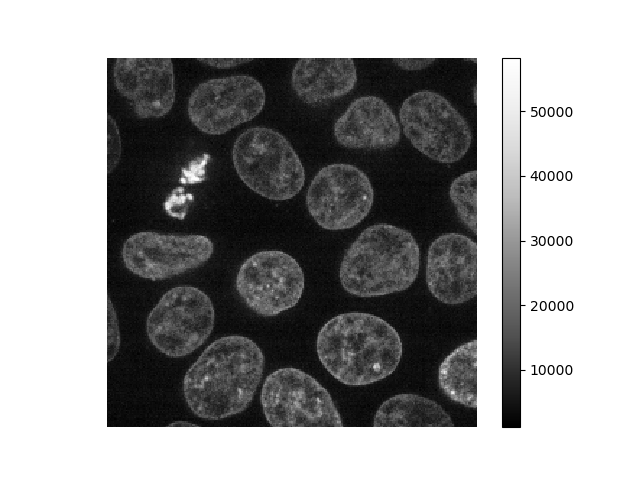
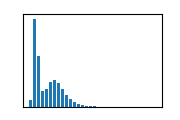

In [4]:
image_ch2 = image[30, 1]
stackview.insight(image_ch2)

In [5]:
manual_annotation = False # change this if you want to annotate something yourself
if manual_annotation:
    viewer = napari.Viewer()
    
    viewer.add_image(image_ch1, blending='additive', colormap='green')
    viewer.add_image(image_ch2, blending='additive', colormap='magenta')
    
    annotation_layer = viewer.add_labels(np.zeros(image_ch1.shape).astype(int))

StackViewNDArray([[0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  ...,
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0],
                  [0, 0, 0, ..., 0, 0, 0]], dtype=int32)
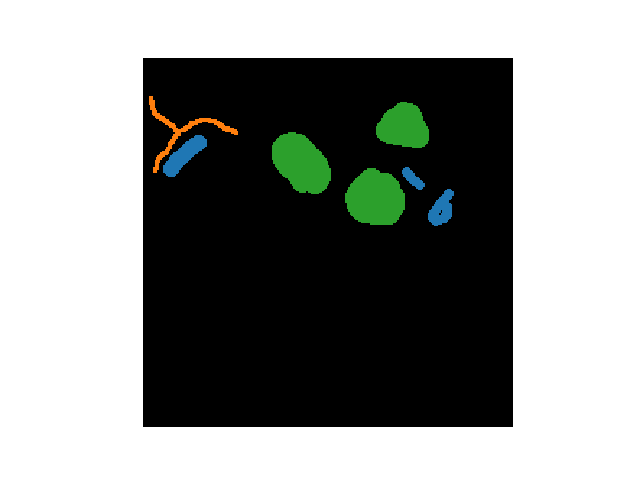

In [6]:
filename = 'cells_annotation.tif'
            
if manual_annotation:
    annotation = annotation_layer.data
    imsave(filename, annotation)
else:
    annotation = imread(filename)
stackview.insight(annotation)

In [7]:
# define features: original image, a blurred version and an edge image
features = "original gaussian_blur=2 sobel_of_gaussian_blur=2"

# this is where the model will be saved
cl_filename = 'test.cl'

apoc.erase_classifier(cl_filename)
classifier = apoc.PixelClassifier(opencl_filename=cl_filename)
classifier.train(features=features, ground_truth=annotation, image=[image_ch1, image_ch2])


In [8]:
annotation.shape

(256, 256)

C:\Users\rober\AppData\Local\Temp\ipykernel_46612\2922955394.py:2: UserWarning: cells_result.tif is a low contrast image
  imsave('cells_result.tif', result)


StackViewNDArray([[2, 2, 2, ..., 3, 3, 3],
                  [2, 2, 2, ..., 3, 3, 3],
                  [2, 2, 2, ..., 3, 3, 3],
                  ...,
                  [1, 1, 1, ..., 2, 2, 2],
                  [1, 1, 1, ..., 2, 2, 2],
                  [1, 1, 1, ..., 2, 2, 2]], dtype=uint32)
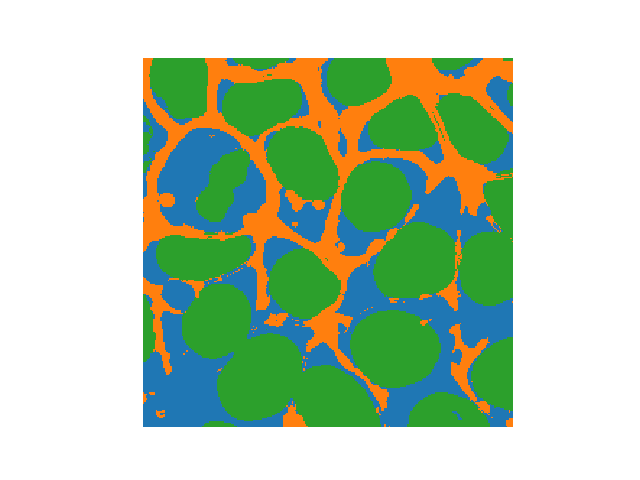

In [9]:
result = classifier.predict(image=[image_ch1, image_ch2])
imsave('cells_result.tif', result)

stackview.insight(result)

## Inspecting a classifier

In some cases, it may be necessary or informative to inspect the classifer you are using. For instance, using multi-channel data for a classifier that was trained on a single channel or vice versa will lead to errors such as this:

cl.OCLArray([[2, 2, 2, ..., 3, 3, 3],
       [2, 2, 2, ..., 3, 3, 3],
       [2, 2, 2, ..., 3, 3, 3],
       ...,
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2],
       [1, 1, 1, ..., 2, 2, 2]], dtype=uint32)
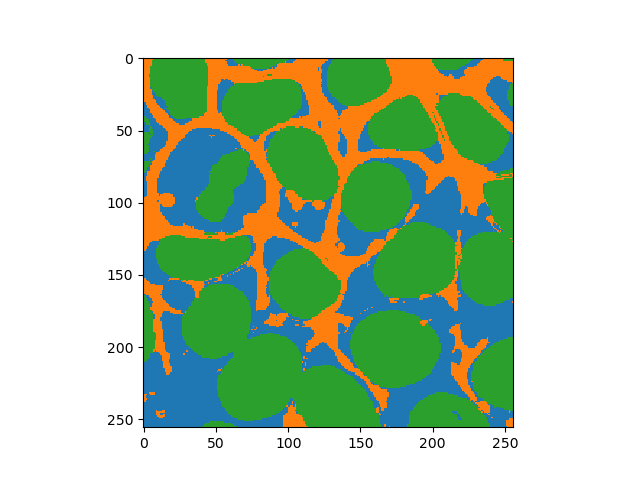

In [10]:
classifier.predict(image=[image_ch1, image_ch2])

To avoid this issue, we can print the classifier info to see which dimensions the classifer expects for the prediction.

Note: For the classifier to work on new data, only the first dimension needs to match. In other words:

- A classifer trained on a `[2, 256, 256]` image will work for new data with dimensions `[2, 512, 512]`
- A classifer trained on a `[2, 256, 256]` image will **not** work for new data with dimensions `[1, 256, 256]`

To obtain all information about the used classifier, you can simply print it like this:

In [11]:
print(classifier)

Classifier type: PixelClassifier
--- Random forest info ---
Used features for training: original gaussian_blur=2 sobel_of_gaussian_blur=2
Ground truth dimensions: 2
Maximum depth: 2
Number of ensembles: 100
Number of classes: 3
Number of features: 6
Number of channels: 2


# Inspecting classifiers

If you want to inspect a classifier from a saved classifier file (`my_classifier.cl)`, you can do this as follows:

In [12]:
with open(cl_filename) as f:
    lines = f.readlines()

content = "\n".join(lines)
print(content.split("*/")[0])

/*

OpenCL RandomForestClassifier

classifier_class_name = PixelClassifier

feature_specification = original gaussian_blur=2 sobel_of_gaussian_blur=2

num_ground_truth_dimensions = 2

num_classes = 3

num_features = 6

max_depth = 2

num_trees = 100

feature_importances = 0.06642466189977739,0.1375424601470076,0.05480555617375141,0.2558279438722818,0.35995680137494374,0.12544257653223811

apoc_version = 0.12.0




Further down in the code of the classifier, you find many `if`-statements, which read from freature images (`ì0`, `ì1`, ...) and store probabilities (`s0`, `s1`, ...). These `if`-statements represent decision trees.

In [13]:
print(content.split("float s2=0;")[1][:1000].replace("\n\n", "\n"))


if(i0<2118.0){
 if(i4<8134.84912109375){
  s0+=1.0;
 } else {
  s0+=0.0012077294685990338;
  s2+=0.998792270531401;
 }
} else {
 if(i1<3335.035888671875){
  s0+=0.8279569892473119;
  s1+=0.005376344086021506;
  s2+=0.16666666666666666;
 } else {
  s1+=1.0;
 }
}
if(i3<6093.5){
 if(i1<3335.035888671875){
  s0+=0.9949174078780177;
  s1+=0.0012706480304955528;
  s2+=0.0038119440914866584;
 } else {
  s1+=1.0;
 }
} else {
 if(i4<8042.8642578125){
  s0+=0.8181818181818182;
  s1+=0.18181818181818182;
 } else {
  s0+=0.0008857395925597874;
  s1+=0.00118098612341305;
  s2+=0.9979332742840271;
 }
}
if(i3<6615.0){
 if(i1<3277.4873046875){
  s0+=0.9859514687100894;
  s1+=0.001277139208173691;
  s2+=0.01277139208173691;
 } else {
  s1+=1.0;
 }
} else {
 if(i1<3244.21044921875){
  s0+=0.0011883541295306002;
  s2+=0.9988116458704694;
 } else {
  s1+=1.0;
 }
}
if(i4<8080.279296875){
 if(i5<654.7950439453125){
  s0+=0.8478260869565217;
  s1+=0.1521


Using utility functions, you can also read out individual lines from the header. Note: These are [private functions]() which are subject to change. If your code breaks when using them, please come back to this notebook and see how it was updated.

In [14]:
apoc._utils._read_something_from_opencl_file(cl_filename, "num_ground_truth_dimensions = ")

'2'